# Formation RNAseq CEA - juin 2023

Session IFB : 5 CPU + 21 GB de RAM

# Part 8: Exploratory analysis I (before normalisation)

   

- 0. 1 - Setting up this R session on IFB core cluster
- 0. 2 - Parameters to be set or modified by the user
- 1 - Loading input data and metadata
- 2 - Quality assessment
- 3 - Saving our results

---

## 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.2.1

Just as in a bash notebook, we can have information about the number of threads available for this session: 

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Thu Jun  1 23:03:26 CEST 2023 ==="                         
[2] "          33624239      fast  jupyter scaburet  R      18:27      1 cpu-node-27"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                         
[4] "       JobID  AllocCPUS        NodeList "                                       
[5] "------------ ---------- --------------- "                                       
[6] "33624239              5     cpu-node-27 "                                       


__

Next we load into this R session the various tools that we will use.   
***DO NOT worry*** if you see a large red output!!   
You should see this large red output only once, when the relevant packages are installed in your home directory. Afterwards, they will be detected as present, and this large red output won't show if you run the cell another time.

In [2]:
## Code cell 2 ##

if (!require("ggfortify", quietly = TRUE)) {
    install.packages("ggfortify")}

if (!require("ggrepel", quietly = TRUE)) {
    install.packages("ggrepel")}

if (!require("affy", quietly = TRUE)) {
    install.packages("affy")}

library("RColorBrewer")
library("ggplot2")
library("stringr")
library("matrixStats")
library("ggfortify")
library("ggrepel")
library("affy")



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgna

and we can verify that all is ok before starting the analysis.

In [3]:
## Code cell 3 ##   

cat("Voici mon environnement de travail avec les paquets de R chargés:\n")
sessionInfo()

Voici mon environnement de travail avec les paquets de R chargés:


R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] matrixStats_0.61.0  stringr_1.4.0       RColorBrewer_1.1-2 
[4] affy_1.68.0         Biobase_2.50.0      BiocGenerics_0.36.1
[7] ggrepel_0.9.1       ggfortify_0.4.16    ggplot2_3.3.5      

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.7            BiocManager

---

## 0.2 - Parameters to be set or modified by the user


- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

In [4]:
## Code cell 4 ##


gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

# In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened
getwd()

setwd("/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet") # temporaire pour mettre le jupynb en place
myfolder <- getwd()

myfolder


[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/pipeline"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

- With a `/` at the end, define the path to the folder where the results of this initial exploratory analysis will be stored:

In [5]:
## Code cell 5 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/Results/pca1/"), recursive = TRUE)

# storing the path to this output folder in a variable
pca1folder <- paste(myfolder,"/Results/pca1/", sep = "")
pca1folder

# listing the content of the folder
print(system(paste("ls -hlt", pca1folder), intern = TRUE) )

Warning message in dir.create(paste(myfolder, "/Results/pca1/", sep = ""), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/pca1' already exists”


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/pca1/"

[1] "total 26M"                                                       
[2] "-rw-rw----+ 1 scaburet scaburet 26M Jun  1 13:17 AllMyData.RData"


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [6]:
## Code cell 6 ##

options(repr.plot.width=15, repr.plot.height=8)

## 1 - Loading input data and metadata

We now need two files:   
- the read counts produced by featureCounts (as in the Pipe_06 notebook), on all 11 samples   
- a metadata file, providing information about the samples, in particular the conditions of the experiment. 

We copy both these file in our personal folder:

In [7]:
## Code cell 7 ##

file.copy("/shared/projects/2312_rnaseq_cea/allData/Results/featurecounts/allSample_paired-unstranded.counts", myfolder)
file.copy("/shared/projects/2312_rnaseq_cea/allData/Data/sampleData-GSE158661.tsv", myfolder)

[1] FALSE

[1] FALSE

You should have obtained 2 TRUE output, and the files should appear in your folder in the left column.

### 1.1 - Loading metadata   

We read the tabulated table and we store the data in a dataframe named `samples`.   
The file has column names, so we set `header=TRUE`, and the separator as a tab (sep = "\t").

In [8]:
## Code cell 8 ##

samples <- read.table("sampleData-GSE158661.tsv", sep="\t", header=TRUE, stringsAsFactors=F)

In [9]:
## Code cell 9 ##

class(samples)

[1] "data.frame"

In [10]:
## Code cell 10 ##

head(samples, n = 12)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
3,SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
4,SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
5,SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
6,SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
7,SRR12730409,dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805166,GSM4805166,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
8,SRR12730410,dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805167,GSM4805167,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
9,SRR12730411,dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805168,GSM4805168,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate3",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver


### 1.2 - Loading counts data   

We read the tabulated table and we store the data in a dataframe named `counts`.   
In addition to specifying the separator and the columns names, we also indicate that lines beginning with "#" are comments and should be ignored.

In [11]:
## Code cell 11 ##

counts <- read.table("allSample_paired-unstranded.counts", sep="\t", header=TRUE, comment="#")

In [12]:
## Code cell 12 ##

class(counts)

[1] "data.frame"

In [13]:
## Code cell 13 ##

head(counts)

,Geneid,Chr,Start,End,Strand,Length,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730408_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730409_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730410_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730411_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730412_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730413_Aligned.sortedByNames.bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000102693.2,chr1,3143476,3144545,+,1070,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000064842.3,chr1,3172239,3172348,+,110,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000051951.6,chr1;chr1;chr1;chr1;chr1;chr1;chr1,3276124;3276746;3283662;3283832;3284705;3491925;3740775,3277540;3277540;3285855;3286567;3287191;3492124;3741721,-;-;-;-;-;-;-,6094,0,0,0,0,0,0,0,1,0,0,0
4,ENSMUSG00000102851.2,chr1,3322980,3323459,+,480,0,0,0,0,0,0,0,0,0,0,1
5,ENSMUSG00000103377.2,chr1,3435954,3438772,-,2819,0,0,0,0,0,0,0,0,0,0,0
6,ENSMUSG00000104017.2,chr1,3445779,3448011,-,2233,0,0,0,0,0,0,0,0,0,0,0


### 1.3 - Data preprocessing   

The `countdata`dataframe contains some columns which are irrelevant to our analysis and will be removed.    
These include the chromosome numbers, start and end positions, gene length and gene biotype. We don't need this information to perform the exploratory and differential expression analysis, hence we drop these with the following code.


In [14]:
## Code cell 14 ##

countdata <- counts[, c(5:17)]
countdata <- countdata[, -c(2)]
countdata <- countdata[, -c(1)]
rownames(countdata) <- counts[,1] 

In [15]:
## Code cell 15 ##

head(countdata)
#head(genes)

,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730403_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730404_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730405_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730406_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730407_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730408_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730409_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730410_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730411_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730412_Aligned.sortedByNames.bam,X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.SRR12730413_Aligned.sortedByNames.bam
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


In [16]:
## Code cell 16 ##

dim(countdata)

[1] 57010    11

The names of the columns are not very easy to read, and most of all, they don't correspond to the sample names present in the first column of the metadata, therefore, we cannot have any correspondance between the two information. So we modify the names of the columns in `countdata`, in order to remove the first part in front of the sample number, and then the last part after the `_`. 

In [17]:
## Code cell 17 ##

# We remove the common prefix
colnames(countdata) <- gsub("X.shared.projects.2312_rnaseq_cea.allData.Results.featurecounts.","",colnames(countdata))

# We remove the common suffix
colnames(countdata) <- gsub("_Aligned.sortedByNames.bam","",colnames(countdata))

#colnames(countdata) <- stringr::str_sub(colnames(countdata),65) 
# j'avais trouvé ça, mais je préfère ne pas enlever un nombre de caractères : si on le fait plusieurs fois c'est la cata

In [18]:
## Code cell 18 ##

head(countdata)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


In [19]:
## Code cell 19 ##

head(countdata)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


To ensure the metadata `samples` and `countdata` dataframes have the same samples names, we run the code below.    
This will return TRUE if the names in both files are the same. In all there are 11 samples in both files.

In [20]:
## Code cell 20 ##

table(colnames(countdata)==samples$SampleID)


TRUE 
  11 

### 1.4 - Filtering out genes with a low expression

For many analysis methods it is advisable to filter out as many genes as possible before the analysis to decrease the impact of multiple testing correction on false discovery rates.   
This is normally done by filtering out genes with low numbers of reads and thus likely to be uninformative from a biological point of view.
(With DESeq2, the tool that we will use later for differential analysis, this is not necessary as it applies independent filtering during the analysis.)   
In addition, filtering out genes that are very lowly expressed does reduce the size of the data matrix, meaning that less memory is required and processing steps are carried out faster.

Here, we will keep all genes where the total number of reads across all 11 samples is greater than 10.   
We count how many genes we have at first (= how many rows): 

In [21]:
## Code cell 21 ##

# check dimension of count matrix
dim(countdata)

# 57010 11

[1] 57010    11

For each gene, we compute the total count of read in all samples, and compare to our threshold. We count the number of genes passing the test.

In [22]:
## Code cell 22 ##


# keeping outcome in vector of 'logicals' (ie TRUE or FALSE, or NA)
keep <- rowSums(countdata) > 10

# summary of test outcome: number of genes in each class:
table(keep, useNA="always") 

keep
FALSE  TRUE  <NA> 
34083 22927     0 

We extract those genes, and store them in a new dataframe

In [23]:
## Code cell 23 ##


# subset genes where test was TRUE
countdata2 <- countdata[keep,]
# check dimension of new count matrix
dim(countdata2)

# 22927 11

[1] 22927    11

## 2 - Quality assessment

Before moving on to doing the actual differential expression analysis, it is important to assess the quality of our data.   
Quality control is an important step in any data analysis. Since our purpose is to identify differentially expressed genes, we will exclude samples with anomalies that will render our results inconclusive. This will also enable us to visually appreciate our data. In the ensuing steps, we will explore our data using boxplots, PCA, density plots and heatmaps.


### 2.1 - Initial visualization

Differential expression calculations with DESeq2 uses raw read counts as input, but for visualization purposes we use transformed counts.

Why not raw counts? Two issues:

    - Raw counts range is very large: some highly expressed genes can have hundreds of thousands of reads
    - Variance increases with mean gene expression, and this has impact on assessing the relationships.
    
Let's display the range of expression of our raw read counts:

In [24]:
## Code cell 24 ##

summary(countdata2)

  SRR12730403      SRR12730404      SRR12730405      SRR12730406    
 Min.   :     0   Min.   :     0   Min.   :     0   Min.   :     0  
 1st Qu.:     5   1st Qu.:     4   1st Qu.:     4   1st Qu.:     4  
 Median :    70   Median :    60   Median :    50   Median :    56  
 Mean   :  1884   Mean   :  1471   Mean   :  1338   Mean   :  1393  
 3rd Qu.:  1435   3rd Qu.:  1174   3rd Qu.:  1022   3rd Qu.:  1095  
 Max.   :380993   Max.   :294250   Max.   :460910   Max.   :465330  
  SRR12730407      SRR12730408      SRR12730409      SRR12730410      
 Min.   :     0   Min.   :     0   Min.   :     0   Min.   :     0.0  
 1st Qu.:     3   1st Qu.:     3   1st Qu.:     3   1st Qu.:     3.0  
 Median :    51   Median :    55   Median :    43   Median :    38.0  
 Mean   :  1549   Mean   :  1411   Mean   :  1152   Mean   :  1218.1  
 3rd Qu.:  1222   3rd Qu.:  1180   3rd Qu.:   918   3rd Qu.:   901.5  
 Max.   :254944   Max.   :212782   Max.   :169735   Max.   :187547.0  
  SRR12730411       

We also can see that few outliers affect distribution visualization:

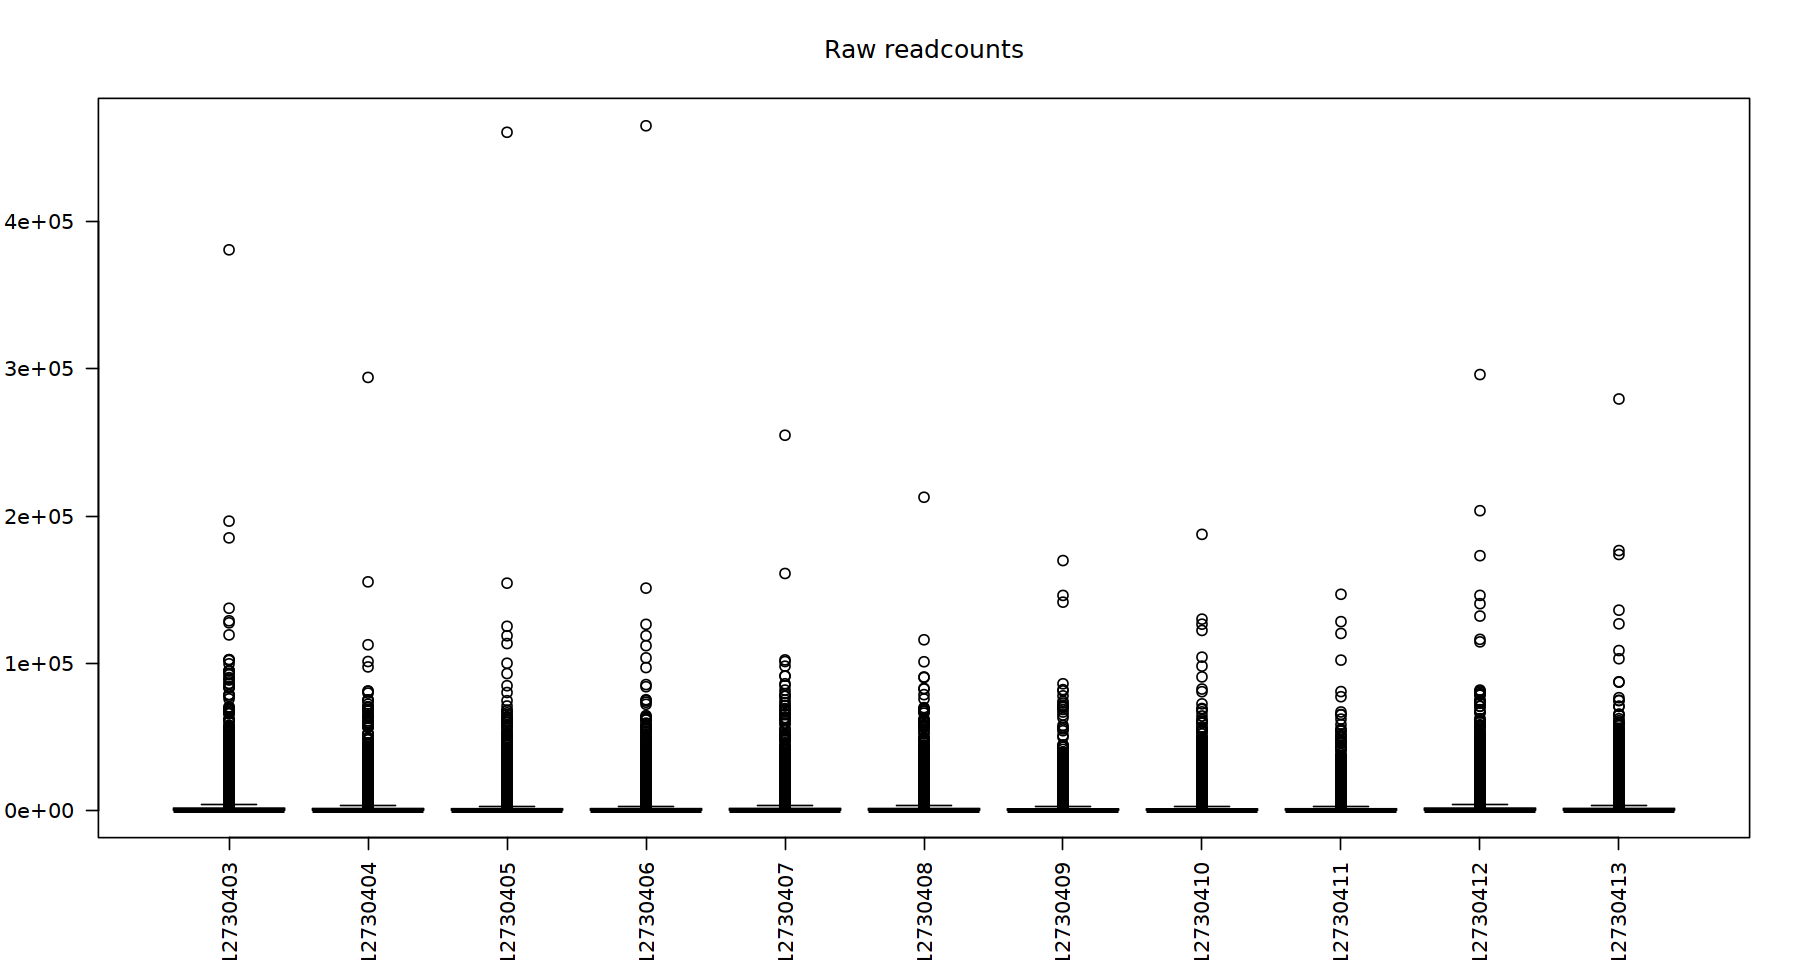

In [26]:
## Code cell 25 ##

boxplot(countdata2, main='Raw readcounts', las=2)


We can see that variance increases with the average level of expression by plotting standard deviation vs mean expression:

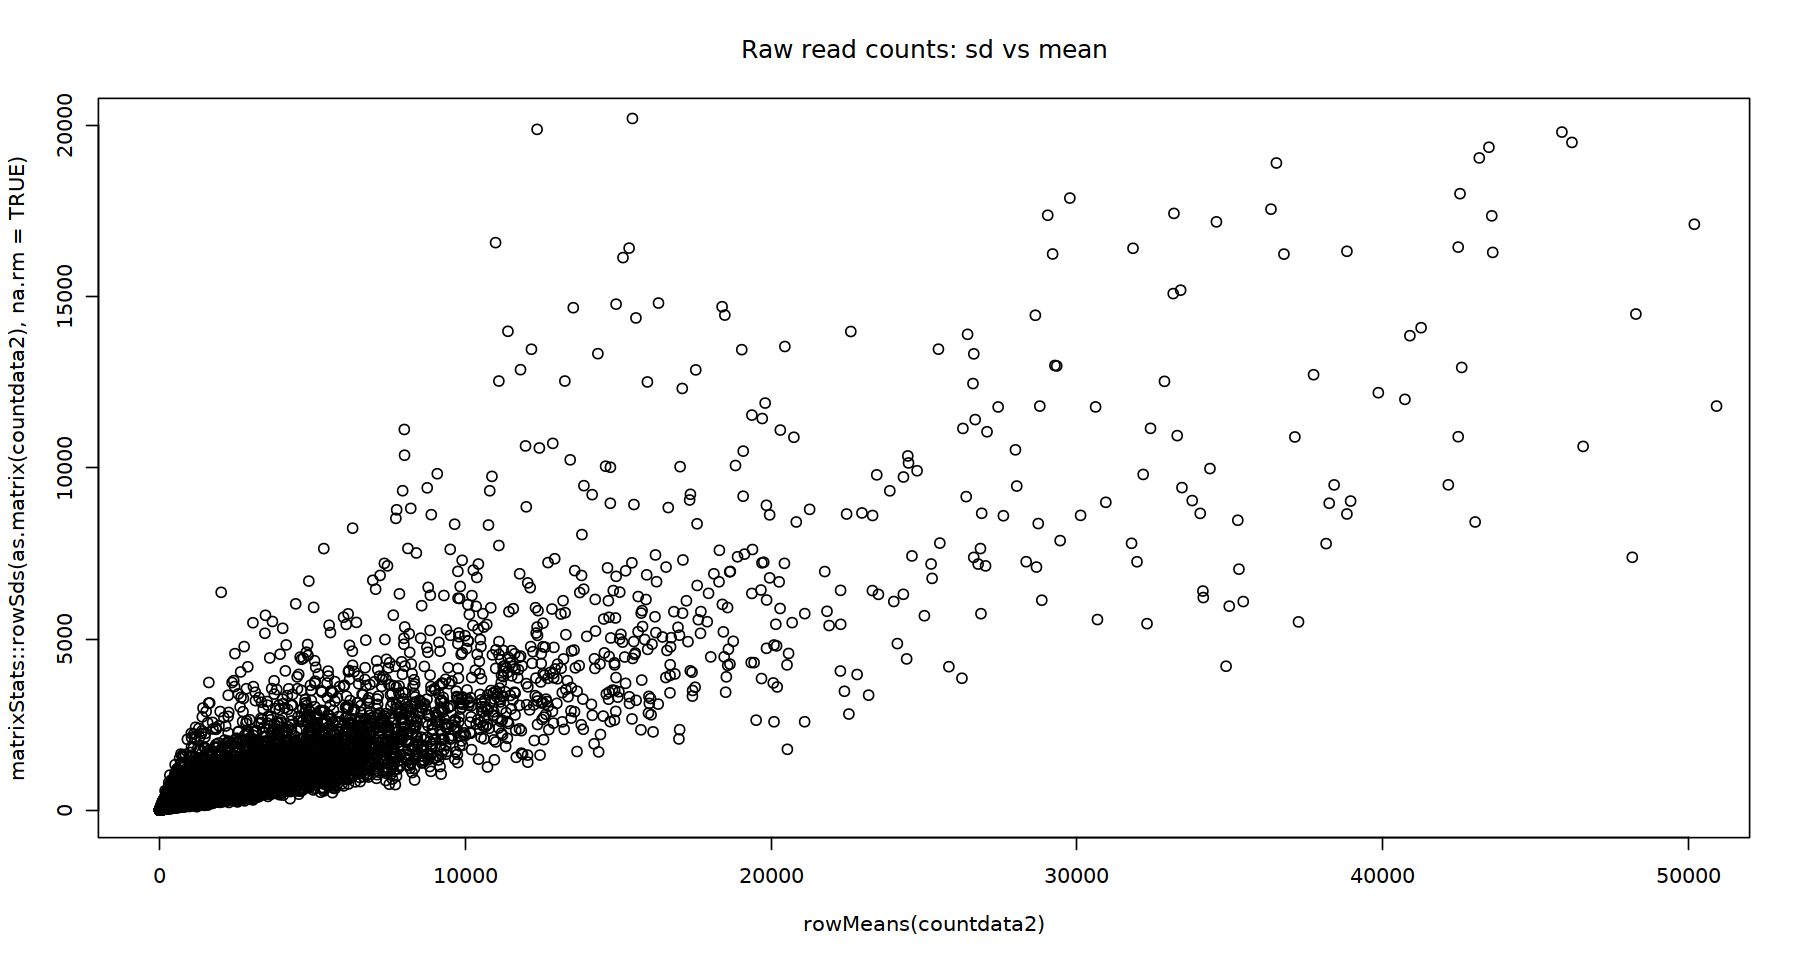

In [27]:
## Code cell 26 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(countdata2), matrixStats::rowSds(as.matrix(countdata2), na.rm=TRUE), 
     main='Raw read counts: sd vs mean', 
     xlim=c(0,50000),
     ylim=c(0,20000))

### 2.2 -  Data transformation and visualization

To avoid problems posed by raw counts, they can be transformed. Several transformation methods exist to limit the dependence of variance on mean gene expression:

    - Simple log2 transformation
    - VST : variance stabilizing transformation
    - rlog : regularized log transformation

For the moment, we are going to use only the first one to perform this first exploratory analysis on non-normalised data.   
The two other types of transformation are available in the DESeq2 package, that we will used in the next jupyter notebook.  
 

### 2.3 - log2 transformation

This is one of the most used transformation in transcriptomics, as it helps to normalize the data (with the meaning of changing the data distribution to one closer to the normal distribution), and it enables a better visualization of low counts.   
    
Because some genes are not expressed (detected) in some samples, their counts are 0. As log2(0) returns -Inf in R which triggers errors by some functions, we add 1 to every count value to create ‘pseudocounts’. The lowest value then is 1, or 0 on the log2 scale (log2(1) = 0).

In [28]:
## Code cell 27 ##

# Get log2 counts
logcounts <- log2(countdata2 + 1)
# summary(logcounts[,1]) # summary for first column
 summary(logcounts) # summary for each column

  SRR12730403      SRR12730404      SRR12730405      SRR12730406    
 Min.   : 0.000   Min.   : 0.000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.: 2.585   1st Qu.: 2.322   1st Qu.: 2.322   1st Qu.: 2.322  
 Median : 6.150   Median : 5.931   Median : 5.672   Median : 5.833  
 Mean   : 6.523   Mean   : 6.266   Mean   : 6.097   Mean   : 6.219  
 3rd Qu.:10.488   3rd Qu.:10.199   3rd Qu.: 9.999   3rd Qu.:10.098  
 Max.   :18.539   Max.   :18.167   Max.   :18.814   Max.   :18.828  
  SRR12730407     SRR12730408      SRR12730409      SRR12730410    
 Min.   : 0.00   Min.   : 0.000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.: 2.00   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000  
 Median : 5.70   Median : 5.807   Median : 5.459   Median : 5.285  
 Mean   : 6.09   Mean   : 6.164   Mean   : 5.870   Mean   : 5.785  
 3rd Qu.:10.26   3rd Qu.:10.206   3rd Qu.: 9.844   3rd Qu.: 9.818  
 Max.   :17.96   Max.   :17.699   Max.   :17.373   Max.   :17.517  
  SRR12730411      SRR12730412      SRR12

We will check the distribution of read pseudocounts using a boxplot and add some colour to see if there is any difference between sample groups.

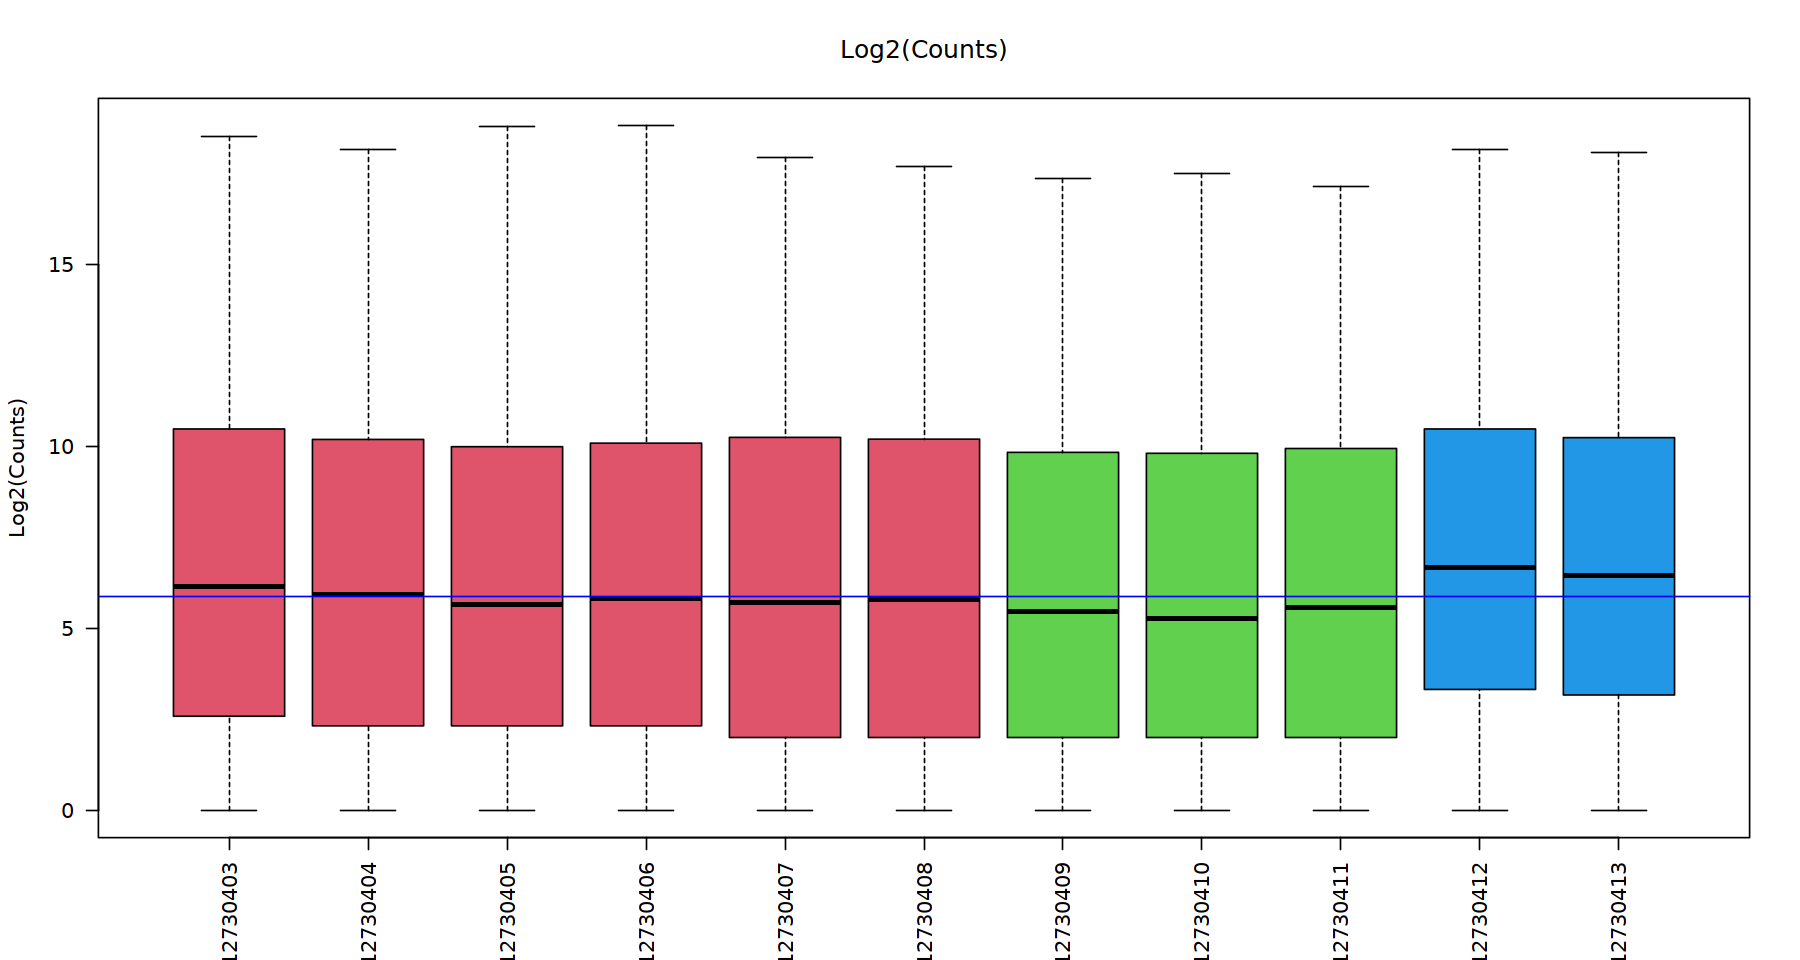

In [30]:
## Code cell 28 ##

# make a colour vector
conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots
boxplot(logcounts,
        xlab="",
        ylab="Log2(Counts)",
        las=2,
        col=conditionColor,
        main="Log2(Counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(as.matrix(logcounts)), col="blue")

From the boxplot, we see that overall the density distributions of raw log-counts are not identical but still not very different from one sample to another.   
If a sample is really far above or below the blue horizontal line (overall median) we may need to investigate that sample further.

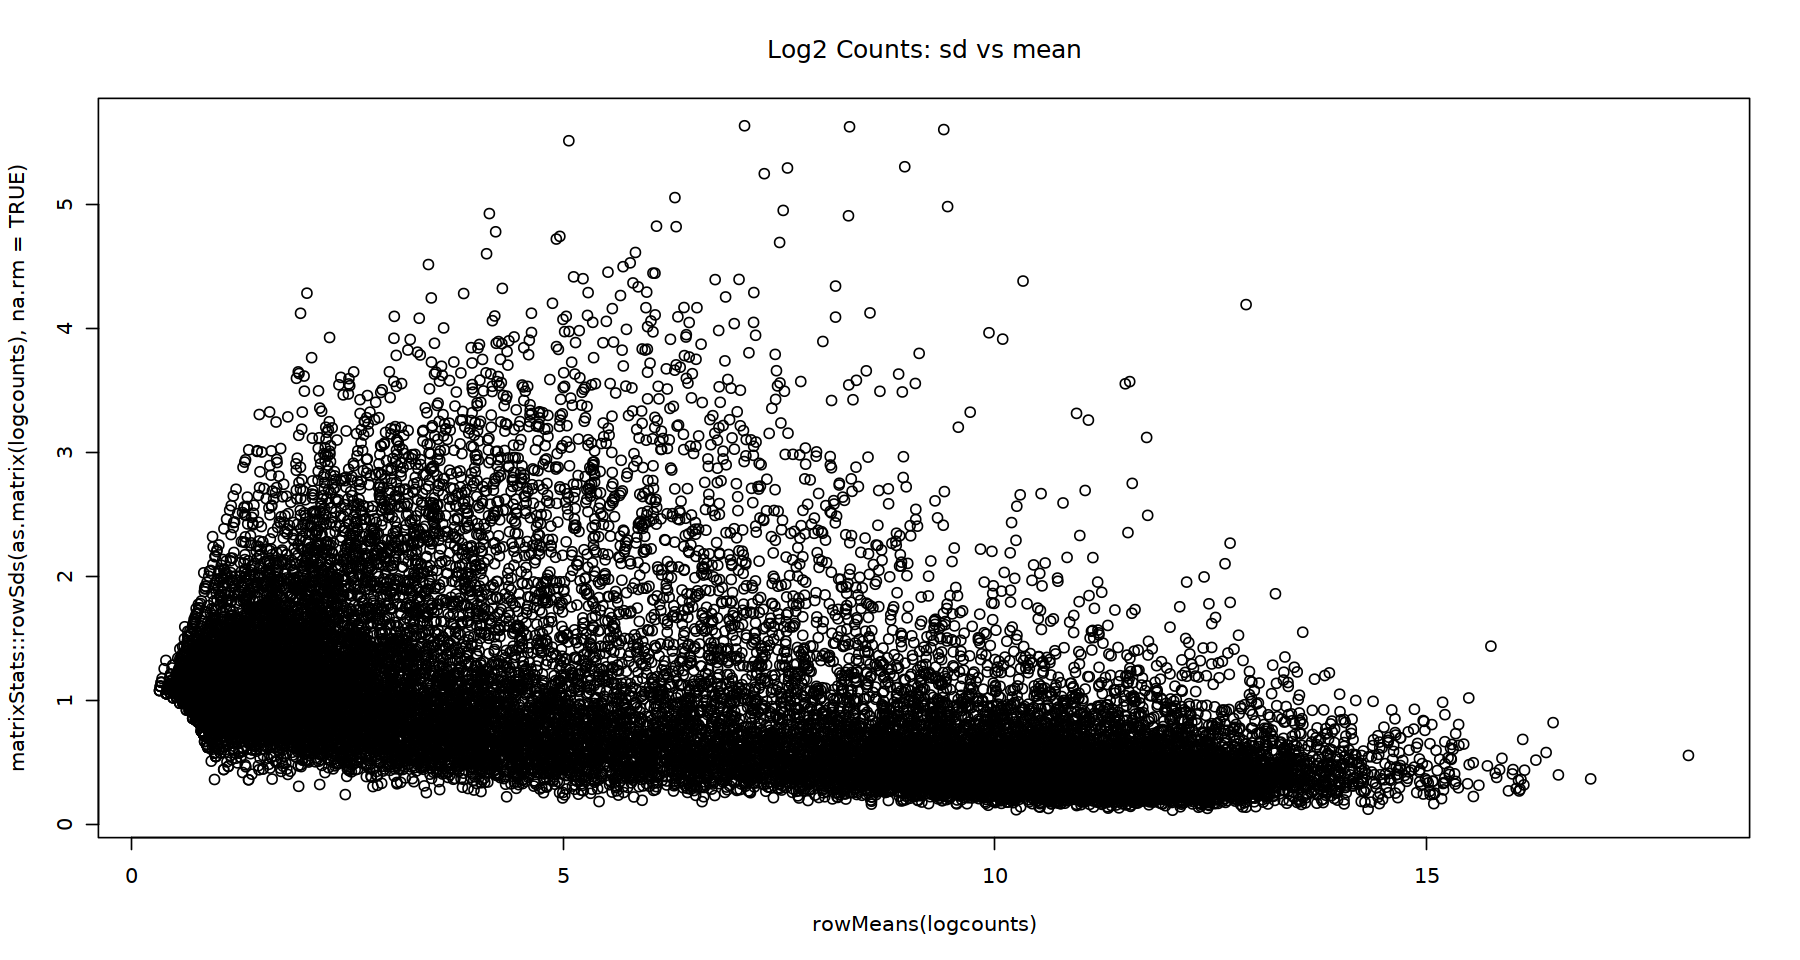

In [31]:
## Code cell 29 ##

# Log2 counts standard deviation (sd) vs mean expression
plot(rowMeans(logcounts), matrixStats::rowSds(as.matrix(logcounts), na.rm=TRUE), 
     main='Log2 Counts: sd vs mean')

In contrast to raw counts, with log2 transformed counts, lowly expressed genes (mean expression around 5 or below) show higher variation than highly expressed genes (mean expression above 10-12).

### 2.4 - Principal Component Analysis

A principal component analysis (PCA) is an unsupervised method used to explore the data variance structure by reducing its dimensions to a few principal components (PC) that explain the greatest variation in the data.  PCA is an example of an unsupervised analysis, where we don’t specify the grouping of the samples.  
If the experiment is well controlled and has worked well, we should find that replicate samples cluster closely, whilst the greatest sources of variation in the data should be between treatments/sample groups.   
It is also an incredibly useful tool for checking for outliers and batch effects.

To run the PCA on non-normalized data, we will use the log2 transformation only, that is the `logcounts` dataframe that we generated above. 
In PCA, the variables are genes, and should be in columns. So in the code below, the `t()` function is used to transpose the dataframe: the result is a new dataframe with samples as rows and genes as columns.

In [32]:
## Code cell 30 ##

tlogcounts <- t(logcounts)
dim(tlogcounts)

[1]    11 22927

To plot the PCA results we will use the autoplot function from the `ggfortify` package (Tang, Horikoshi, and Li 2016). `ggfortify` is built on top of `ggplot2` and is able to recognise common statistical objects such as PCA results or linear model results and automatically generate summary plot of the results in an appropriate manner.

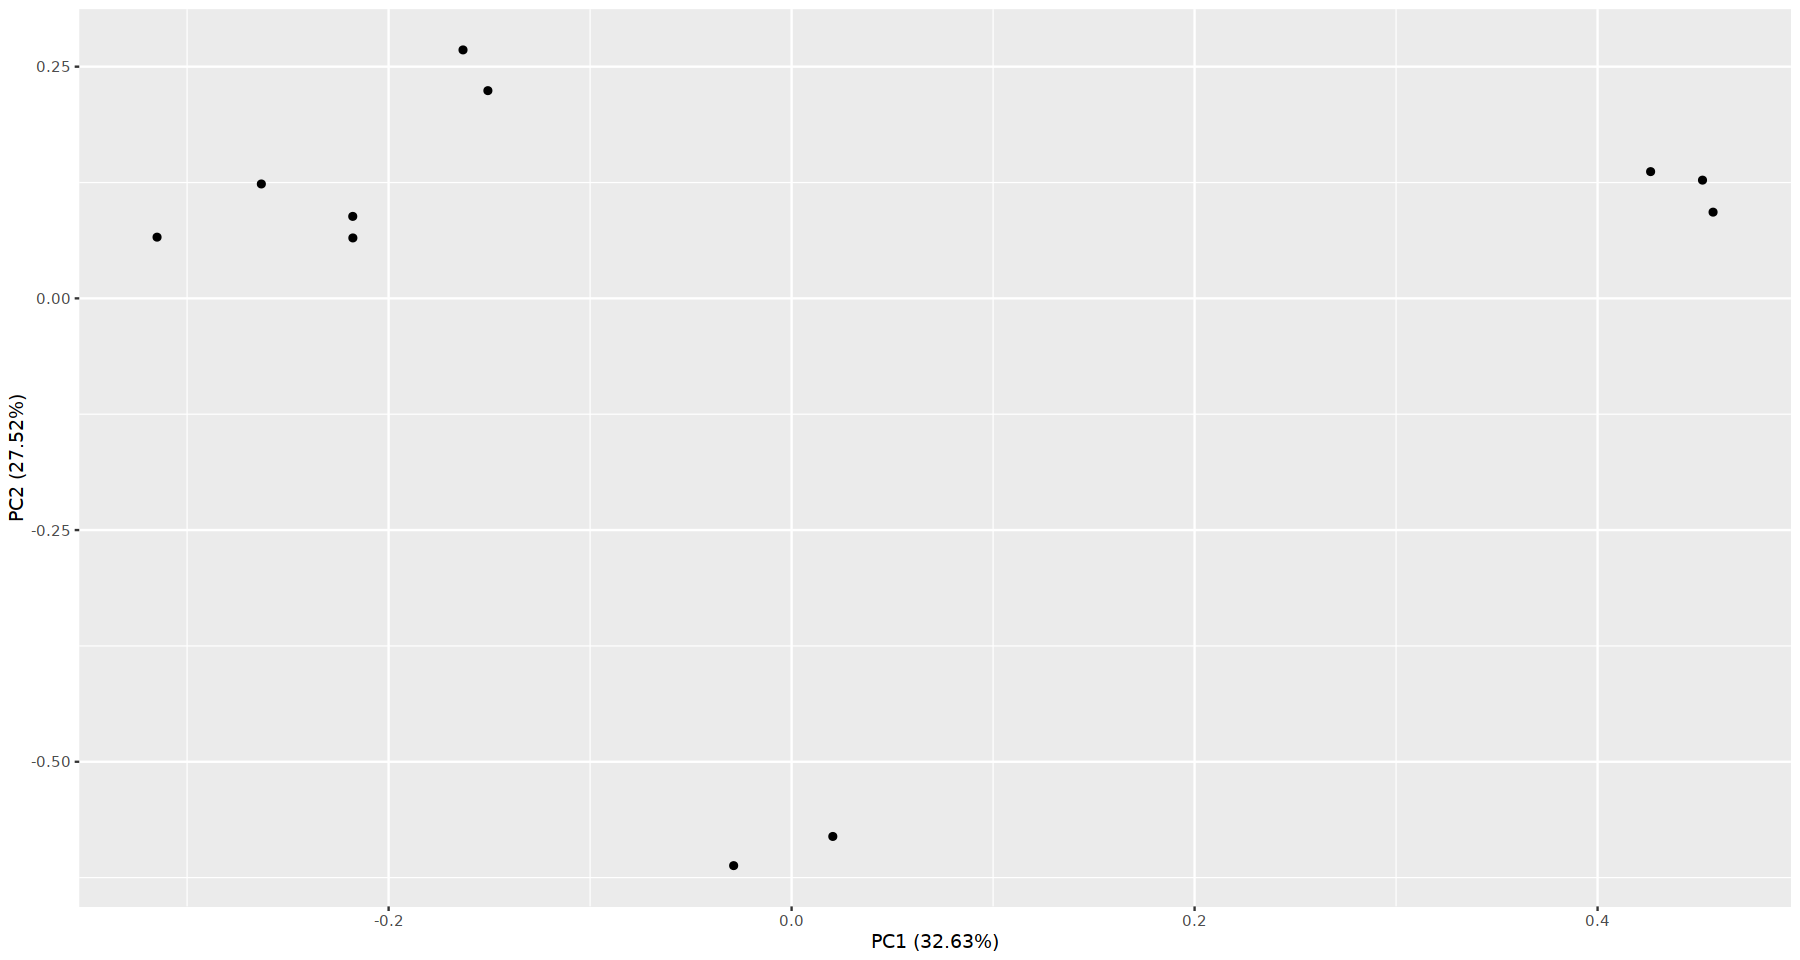

In [33]:
## Code cell 31 ##

# run PCA
PCAdata <- prcomp(tlogcounts)

# plot PCA
autoplot(PCAdata)

Without the names of the samples, or colours indicating their group, we cannot see if they cluster correctly.    
So we add colours and labels to the PCA plot.   
The package `ggrepel` allows us to add text to the plot, but ensures that points that are close together don’t have their labels overlapping (they repel each other).

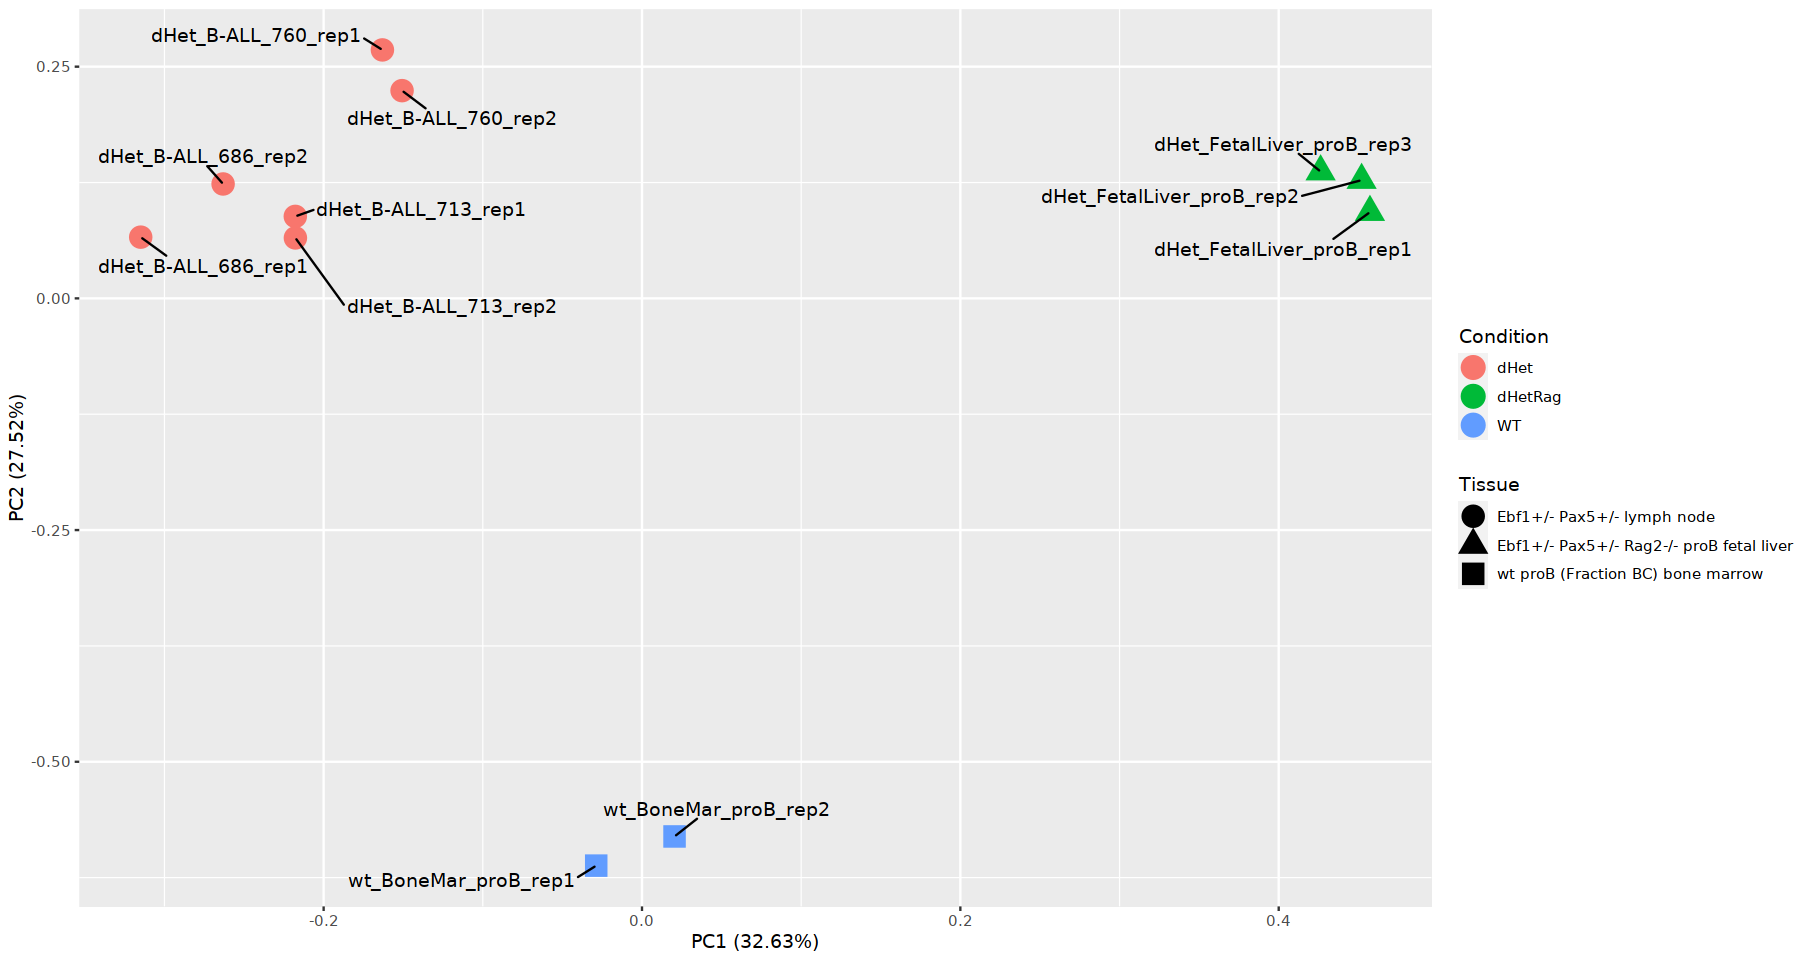

In [34]:
## Code cell 32 ##

autoplot(PCAdata,
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
        geom_text_repel(aes(x=PC1, y=PC2, label=SampleName), box.padding = 0.8)


We can see that the first Principal Component (explaining the largest source of variation) shows variation between samples from different conditions (the effect of interest), while the second PC (explaining the second largest source of variation) displays sample differences due to WT vs mutant genotypes.   
It seems that there is no batch effect, but let's verify if none appears in the next PCs.  

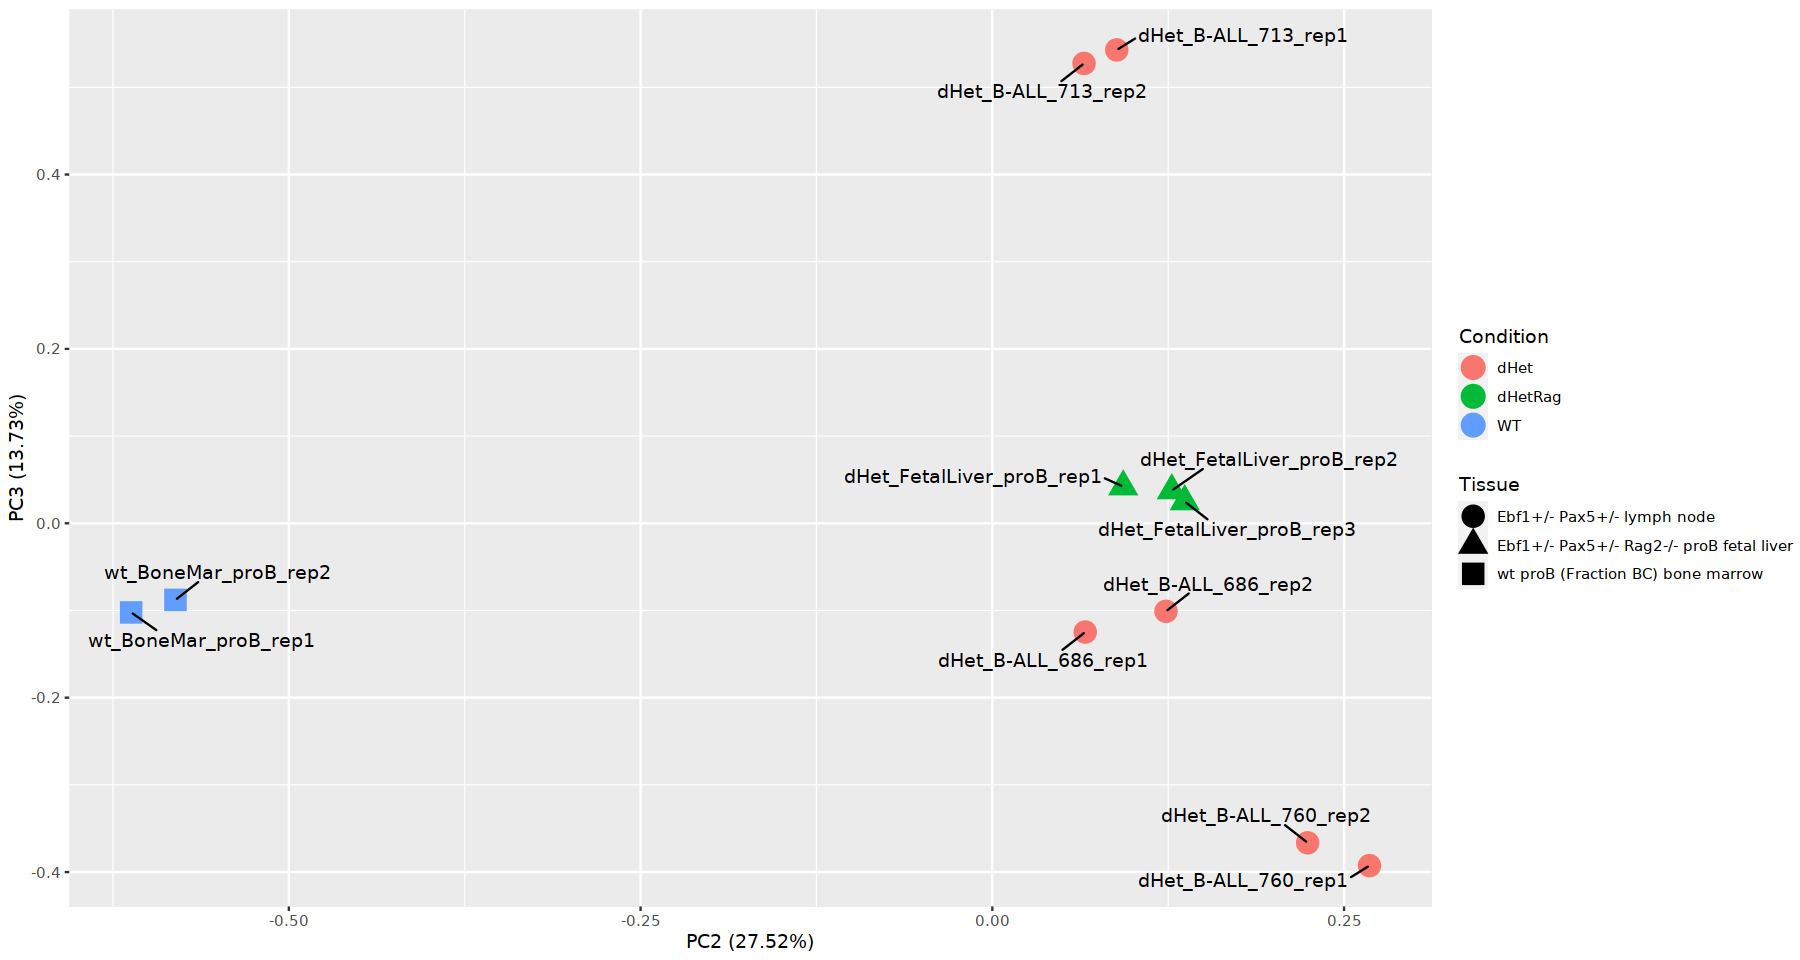

In [37]:
## Code cell 33 ##

autoplot(PCAdata,
         x = 2,    # PC2
         y = 3,    # PC3
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
    geom_text_repel(aes(x=PC2, y=PC3, label=SampleName), box.padding = 0.8)


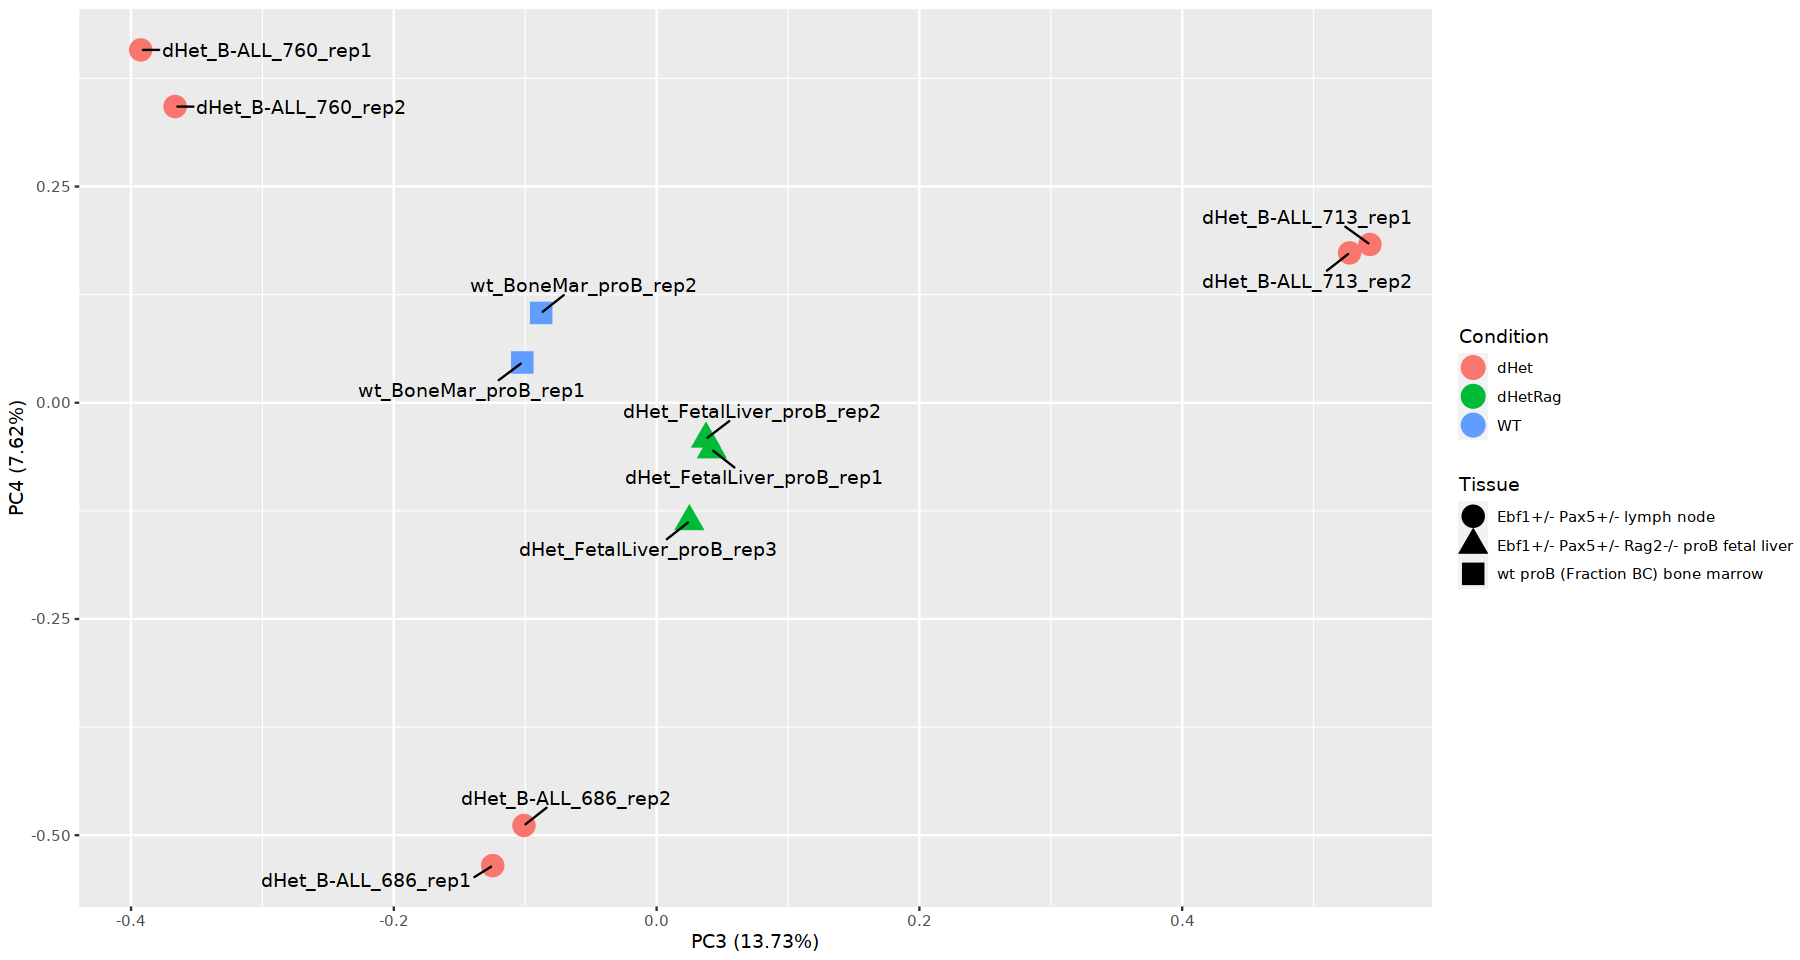

In [38]:
## Code cell 34 ##

autoplot(PCAdata,
         x = 3,    # PC3
         y = 4,    # PC4
         data = samples, 
         colour="Condition", 
         shape="Tissue",
         size=6) +
    geom_text_repel(aes(x=PC3, y=PC4, label=SampleName), box.padding = 0.8)


On the basis of these last two plots, we cannot see a clear effect of a given factor to the variation depicted in PC3 and PC4, except maybe the difference between mice.

### 2.5 - Hierarchical clustering

This  representation can also be used to cluster the samples based on dissimilarity indexes. More information can be found with ?hclust (or in the Contextual Help panel on the right, that can be opened via the Help menu).

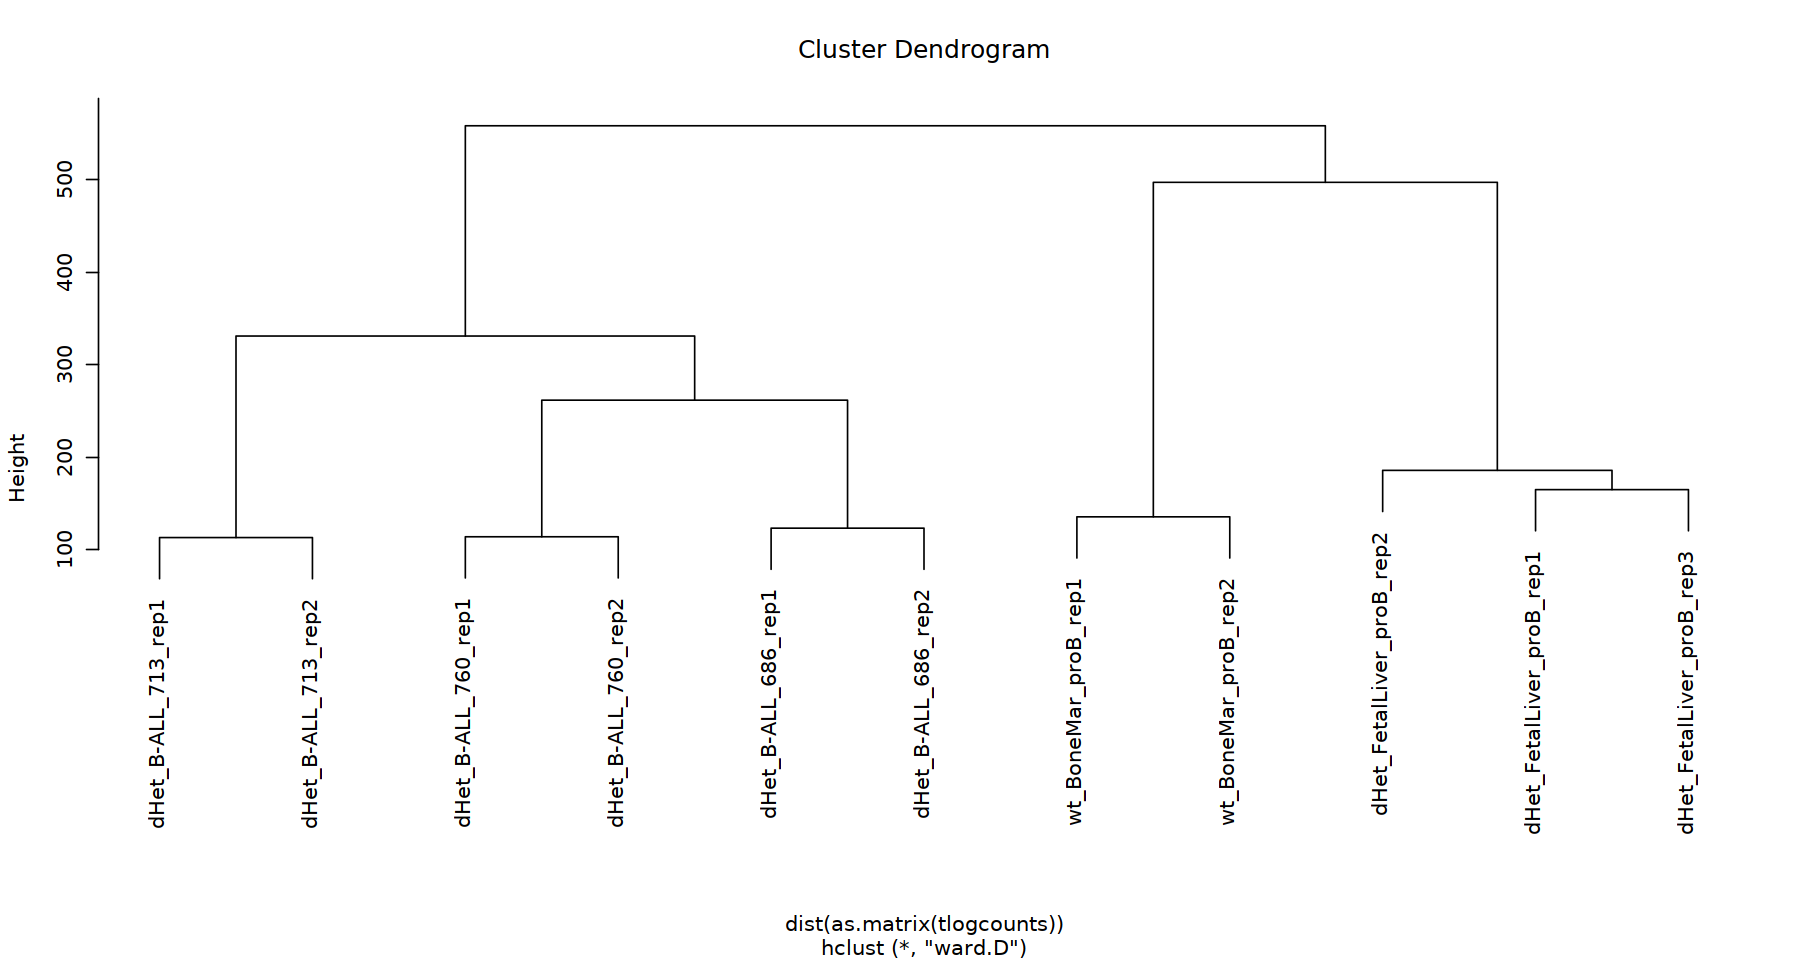

In [39]:
## Code cell 35 ##

clusters <- hclust(dist(as.matrix(tlogcounts)), method ="ward.D")
plot(clusters, labels = samples$SampleName)
    

We can see that our samples are grouped correctly, and that replicates from the same mouse cluster together, as expected.

### 2.6 - Density plot

A Density Plot can be used to visualize the distribution of data over a continuous interval. In RNA-seq analysis, this could be used to detect the presence or absence of batch effects in the data. Batch effects may be introduced through different experimental platforms, laboratory conditions, different sources of samples, different technicians, etc, and may introduce spurious variability which is not due to the condition under study (cancerous state of B and pro-B cells).   
This [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4636836/) comprehensively discusses batch effects and how they can be corrected.

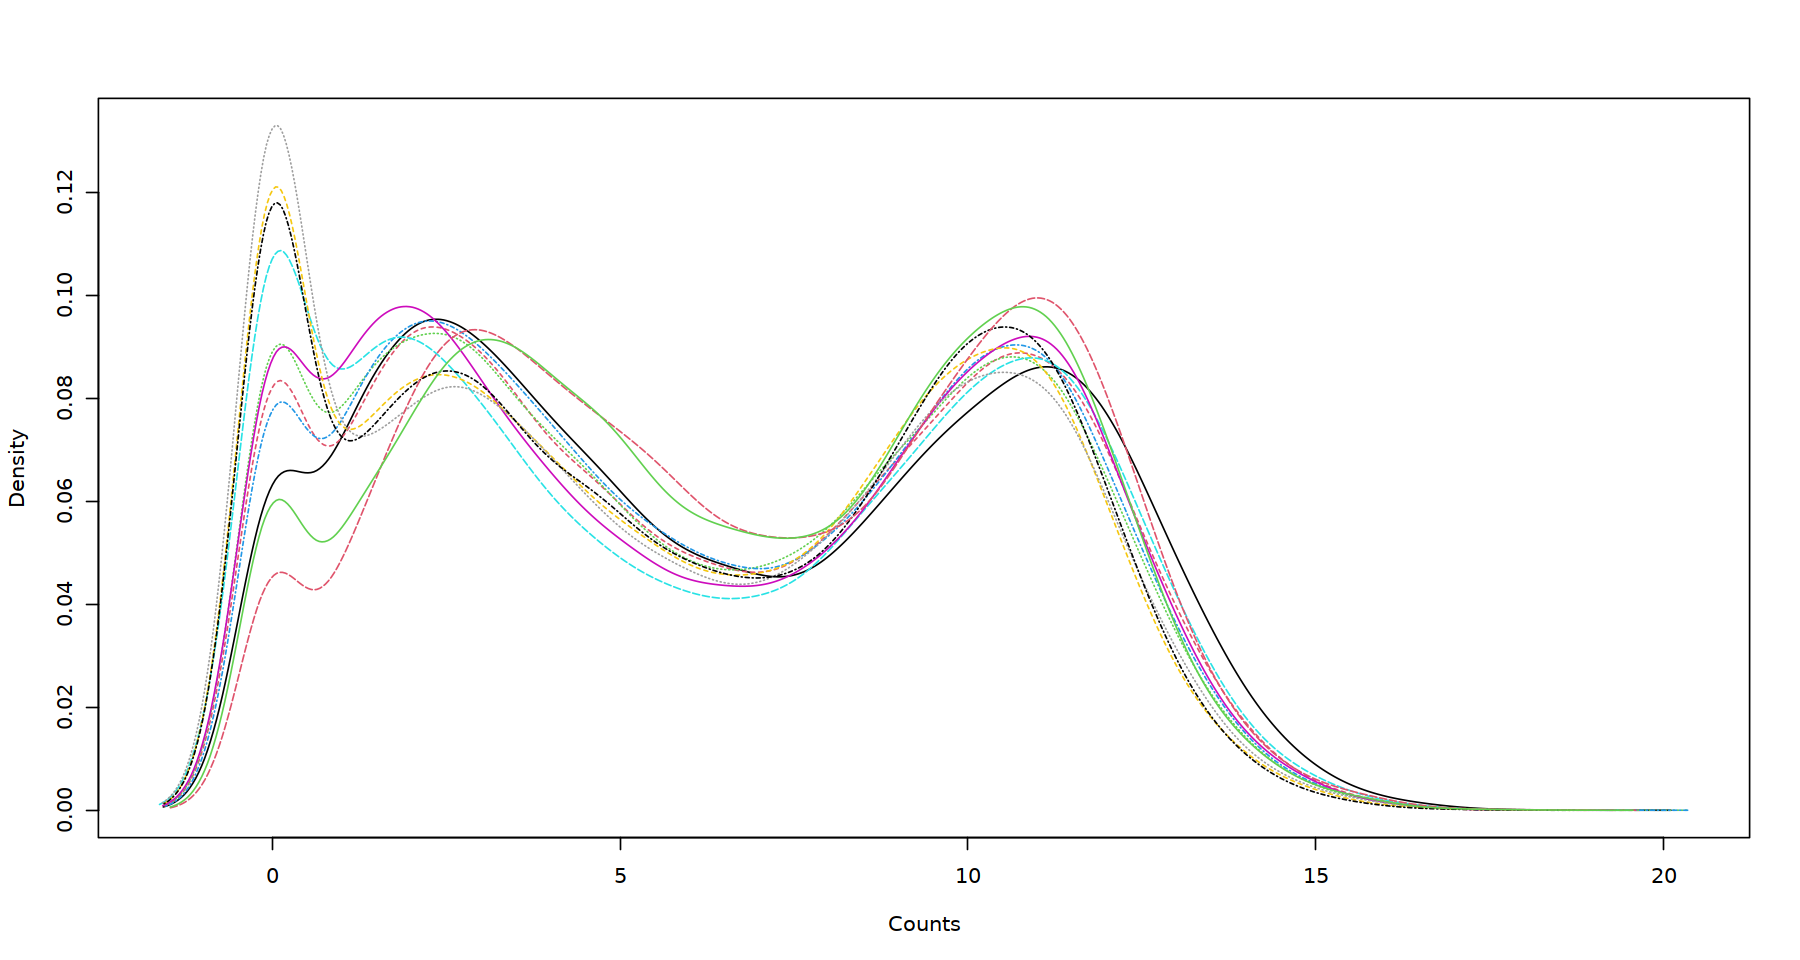

In [40]:
## Code cell 36 ##

plotDensity(as.matrix(logcounts), xlab("Density"),ylab("Counts"), col=1:11)

#plotDensity(logcounts, col=1:11,lwd=2,lty=1,xlab("Density"),ylab("Counts"))

The density plots overlap for all samples, none stand out as having a different profile.   
This confirms that no batch effect is visible in our data that would need to be correted before going on with normalisation.   

To see examples of batch effects, you can have a look [there](https://evayiwenwang.github.io/Managing_batch_effects/detect.html). 

## 3 - Saving our results

We can save all the R objects created in this session in a single R object.   
This will help us to reload our dataframes without having to run the same commands.   

In [41]:
## Code cell 37 ##  

ls()
save.image(file=paste0(pca1folder,"AllMyData.RData"))

[1] "clusters"           "conditionCol"       "conditionColor"    
 [4] "countdata"          "countdata2"         "counts"            
 [7] "gohome"             "keep"               "logcounts"         
[10] "myfolder"           "pca1folder"         "PCAdata"           
[13] "samples"            "session_parameters" "tlogcounts"

---
___

Now we go on with the normalisation of read counts and differential expression analysis using `DESeq2`.  
  
**=> Step 9: DESeq2 Normalisation and Differential Expression analysis** 

The jupyter notebook used for the next session will be *Pipe_09-R403-DESeq2-normalisation-DE.ipynb*    
Let's retrieve it in our directory, in order to have a private copy to work on:   

In [42]:
## Code cell 38 ##   

myfolder
file.copy("/shared/projects/2312_rnaseq_cea/pipeline/Pipe_09-R403-DESeq2-normalisation-DE.ipynb", myfolder)

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

[1] TRUE



**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks` folder. Adjust the name with yours and reformat as code cell to run it.

---

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform a exploratory analysis of RNAseq expression data in R.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Claire Vandiedonck - 2021-2022   
Sandrine Caburet - 05/2023   
MAJ : 25/05/2023